<a href="https://colab.research.google.com/github/saivignesh21/droplet-analysis/blob/main/1000cstfi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⬆ Upload your 1000cst zip file (e.g., 1000cst5cm.zip, 1000cst10cm.zip, etc.)


Saving 1000cst5cm.zip to 1000cst5cm.zip


Processing 1000cst5cm.zip: 100%|██████████| 621/621 [00:04<00:00, 152.61it/s]



✅ Saved results to results_1000cst5cm.csv
Initial Diameter D₀ = 6.54 mm
Maximum Diameter Dₘₐₓ = 6.55 mm
Spreading Factor β = 1.003


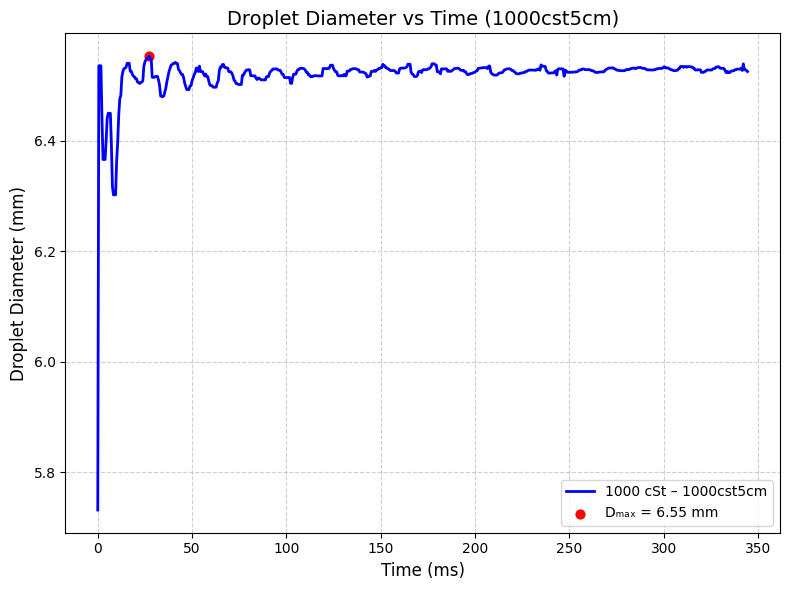

In [ ]:
# ==============================================================
# 🧩 STEP 1: Install & Import Libraries
# ==============================================================
!pip install opencv-python-headless scikit-image tqdm matplotlib --quiet

import os, zipfile, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io
from scipy.signal import medfilt
from scipy.interpolate import interp1d
import pandas as pd

# ==============================================================
# 🗂 STEP 2: Upload Dataset
# ==============================================================
from google.colab import files
print("⬆ Upload your 1000cst zip file (e.g., 1000cst5cm.zip, 1000cst10cm.zip, etc.)")
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

# ==============================================================
# ⚙ Constants
# ==============================================================
FPS = 1800                     # frame rate (Hz)
time_per_frame = 1 / FPS       # seconds per frame
pixels_per_mm = 36.14          # calibration (from ImageJ)
mm_per_pixel = 1 / pixels_per_mm

# ==============================================================
# ⚙ STEP 3: Droplet Processing Function
# ==============================================================
def ensure_gray(img):
    """Convert to grayscale if needed"""
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def process_zip(zip_path):
    """Extracts frames, detects droplet, computes diameter (mm) vs time"""
    extract_folder = zip_path.replace('.zip','')
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_folder)

    frames = sorted([f for f in os.listdir(extract_folder) if f.lower().endswith('.tif')])
    if not frames:
        raise RuntimeError(f"No .tif files found in {zip_path}")

    diam_mm, times = [], []

    for i, fname in enumerate(tqdm(frames, desc=f"Processing {zip_path}")):
        img = io.imread(os.path.join(extract_folder, fname))
        gray = ensure_gray(img)

        # --- Optional crop (focus region, adjust as needed) ---
        roi = gray[500:800, :]

        # --- Thresholding ---
        blur = cv2.GaussianBlur(roi, (5,5), 0)
        _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if np.mean(roi[th==255]) > np.mean(roi[th==0]):
            th = cv2.bitwise_not(th)

        # --- Morphological cleaning ---
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
        th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)

        # --- Find droplet contour ---
        cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            diam_mm.append(np.nan)
            times.append(i * time_per_frame)
            continue

        c = max(cnts, key=cv2.contourArea)
        area_px = cv2.contourArea(c)
        eq_d_px = 2 * np.sqrt(area_px / np.pi)
        eq_d_mm = eq_d_px * mm_per_pixel

        diam_mm.append(eq_d_mm)
        times.append(i * time_per_frame)

    # --- Handle missing data and smooth curve ---
    diam = np.array(diam_mm, float)
    idx = np.arange(len(diam))
    if np.any(np.isnan(diam)):
        f = interp1d(idx[~np.isnan(diam)], diam[~np.isnan(diam)], fill_value="extrapolate")
        diam = f(idx)
    diam = medfilt(diam, 5)

    # --- Compute Metrics ---
    t_ms = np.array(times) * 1000
    D0 = np.median(diam[:5])
    Dmax = np.nanmax(diam)
    Tmax = t_ms[np.argmax(diam)]
    Beta = Dmax / D0

    # --- Save results ---
    csv_name = f"results_{zip_path.replace('.zip', '.csv')}"
    pd.DataFrame({"Time_ms": t_ms, "Diameter_mm": diam}).to_csv(csv_name, index=False)
    print(f"\n✅ Saved results to {csv_name}")
    print(f"Initial Diameter D₀ = {D0:.2f} mm")
    print(f"Maximum Diameter Dₘₐₓ = {Dmax:.2f} mm")
    print(f"Spreading Factor β = {Beta:.3f}")

    return t_ms, diam, Dmax, Tmax, D0, Beta

# ==============================================================
# 📊 STEP 4: Run for 1000 cSt
# ==============================================================
t_ms, diam_mm, Dmax, Tmax, D0, Beta = process_zip(zip_name)

plt.figure(figsize=(8,6))
plt.plot(t_ms, diam_mm, 'b-', linewidth=2, label=f"1000 cSt – {zip_name.replace('.zip','')}")
plt.scatter(Tmax, Dmax, color='r', s=40, label=f"Dₘₐₓ = {Dmax:.2f} mm")
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Droplet Diameter (mm)", fontsize=12)
plt.title(f"Droplet Diameter vs Time ({zip_name.replace('.zip','')})", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


⬆ Upload your 1000cst zip file (e.g., 1000cst5cm.zip, 1000cst10cm.zip, etc.)


Saving 1000cst10cm.zip to 1000cst10cm.zip


Processing 1000cst10cm.zip: 100%|██████████| 409/409 [00:02<00:00, 197.61it/s]



✅ Saved results to results_1000cst10cm.csv
Initial Diameter D₀ = 6.40 mm
Maximum Diameter Dₘₐₓ = 6.68 mm
Spreading Factor β = 1.044


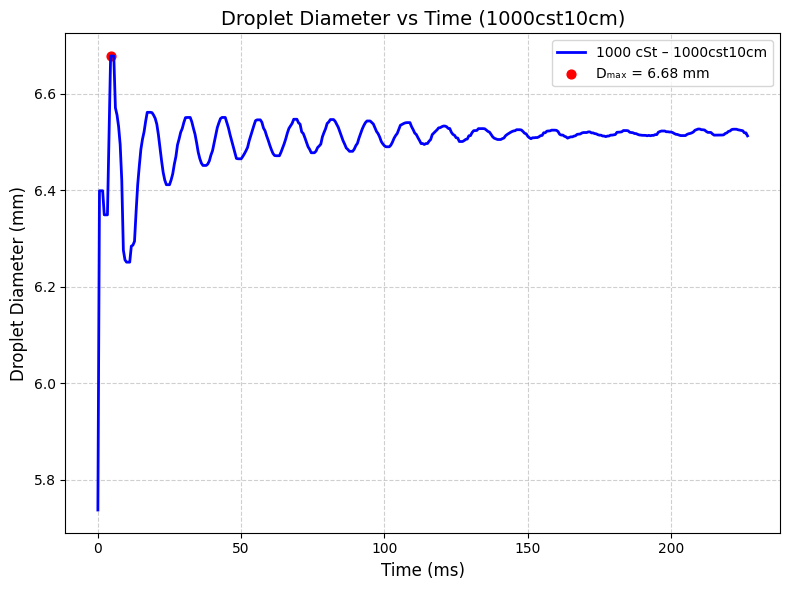

In [ ]:
# ==============================================================
# 🧩 STEP 1: Install & Import Libraries
# ==============================================================
!pip install opencv-python-headless scikit-image tqdm matplotlib --quiet

import os, zipfile, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io
from scipy.signal import medfilt
from scipy.interpolate import interp1d
import pandas as pd

# ==============================================================
# 🗂 STEP 2: Upload Dataset
# ==============================================================
from google.colab import files
print("⬆ Upload your 1000cst zip file (e.g., 1000cst5cm.zip, 1000cst10cm.zip, etc.)")
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

# ==============================================================
# ⚙ Constants
# ==============================================================
FPS = 1800                     # frame rate (Hz)
time_per_frame = 1 / FPS       # seconds per frame
pixels_per_mm = 36.14          # calibration (from ImageJ)
mm_per_pixel = 1 / pixels_per_mm

# ==============================================================
# ⚙ STEP 3: Droplet Processing Function
# ==============================================================
def ensure_gray(img):
    """Convert to grayscale if needed"""
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def process_zip(zip_path):
    """Extracts frames, detects droplet, computes diameter (mm) vs time"""
    extract_folder = zip_path.replace('.zip','')
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_folder)

    frames = sorted([f for f in os.listdir(extract_folder) if f.lower().endswith('.tif')])
    if not frames:
        raise RuntimeError(f"No .tif files found in {zip_path}")

    diam_mm, times = [], []

    for i, fname in enumerate(tqdm(frames, desc=f"Processing {zip_path}")):
        img = io.imread(os.path.join(extract_folder, fname))
        gray = ensure_gray(img)

        # --- Optional crop (focus region, adjust as needed) ---
        roi = gray[500:800, :]

        # --- Thresholding ---
        blur = cv2.GaussianBlur(roi, (5,5), 0)
        _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if np.mean(roi[th==255]) > np.mean(roi[th==0]):
            th = cv2.bitwise_not(th)

        # --- Morphological cleaning ---
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
        th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)

        # --- Find droplet contour ---
        cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            diam_mm.append(np.nan)
            times.append(i * time_per_frame)
            continue

        c = max(cnts, key=cv2.contourArea)
        area_px = cv2.contourArea(c)
        eq_d_px = 2 * np.sqrt(area_px / np.pi)
        eq_d_mm = eq_d_px * mm_per_pixel

        diam_mm.append(eq_d_mm)
        times.append(i * time_per_frame)

    # --- Handle missing data and smooth curve ---
    diam = np.array(diam_mm, float)
    idx = np.arange(len(diam))
    if np.any(np.isnan(diam)):
        f = interp1d(idx[~np.isnan(diam)], diam[~np.isnan(diam)], fill_value="extrapolate")
        diam = f(idx)
    diam = medfilt(diam, 5)

    # --- Compute Metrics ---
    t_ms = np.array(times) * 1000
    D0 = np.median(diam[:5])
    Dmax = np.nanmax(diam)
    Tmax = t_ms[np.argmax(diam)]
    Beta = Dmax / D0

    # --- Save results ---
    csv_name = f"results_{zip_path.replace('.zip', '.csv')}"
    pd.DataFrame({"Time_ms": t_ms, "Diameter_mm": diam}).to_csv(csv_name, index=False)
    print(f"\n✅ Saved results to {csv_name}")
    print(f"Initial Diameter D₀ = {D0:.2f} mm")
    print(f"Maximum Diameter Dₘₐₓ = {Dmax:.2f} mm")
    print(f"Spreading Factor β = {Beta:.3f}")

    return t_ms, diam, Dmax, Tmax, D0, Beta

# ==============================================================
# 📊 STEP 4: Run for 1000 cSt
# ==============================================================
t_ms, diam_mm, Dmax, Tmax, D0, Beta = process_zip(zip_name)

plt.figure(figsize=(8,6))
plt.plot(t_ms, diam_mm, 'b-', linewidth=2, label=f"1000 cSt – {zip_name.replace('.zip','')}")
plt.scatter(Tmax, Dmax, color='r', s=40, label=f"Dₘₐₓ = {Dmax:.2f} mm")
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Droplet Diameter (mm)", fontsize=12)
plt.title(f"Droplet Diameter vs Time ({zip_name.replace('.zip','')})", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


⬆ Upload your 1000cst zip file (e.g., 1000cst5cm.zip, 1000cst10cm.zip, etc.)


Saving 1000cst20cm.zip to 1000cst20cm.zip


Processing 1000cst20cm.zip: 100%|██████████| 394/394 [00:03<00:00, 118.75it/s]



✅ Saved results to results_1000cst20cm.csv
Initial Diameter D₀ = 6.14 mm
Maximum Diameter Dₘₐₓ = 6.61 mm
Spreading Factor β = 1.077


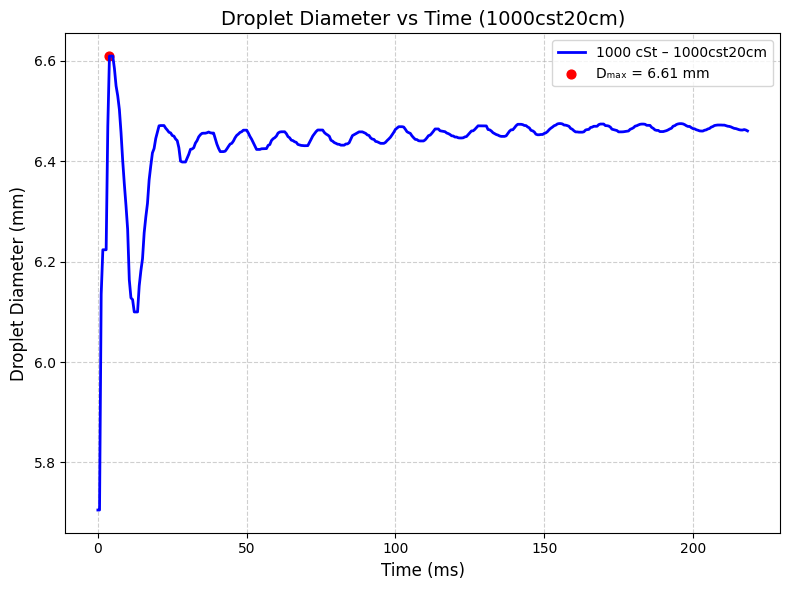

In [ ]:
# ==============================================================
# 🧩 STEP 1: Install & Import Libraries
# ==============================================================
!pip install opencv-python-headless scikit-image tqdm matplotlib --quiet

import os, zipfile, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io
from scipy.signal import medfilt
from scipy.interpolate import interp1d
import pandas as pd

# ==============================================================
# 🗂 STEP 2: Upload Dataset
# ==============================================================
from google.colab import files
print("⬆ Upload your 1000cst zip file (e.g., 1000cst5cm.zip, 1000cst10cm.zip, etc.)")
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

# ==============================================================
# ⚙ Constants
# ==============================================================
FPS = 1800                     # frame rate (Hz)
time_per_frame = 1 / FPS       # seconds per frame
pixels_per_mm = 36.14          # calibration (from ImageJ)
mm_per_pixel = 1 / pixels_per_mm

# ==============================================================
# ⚙ STEP 3: Droplet Processing Function
# ==============================================================
def ensure_gray(img):
    """Convert to grayscale if needed"""
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def process_zip(zip_path):
    """Extracts frames, detects droplet, computes diameter (mm) vs time"""
    extract_folder = zip_path.replace('.zip','')
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_folder)

    frames = sorted([f for f in os.listdir(extract_folder) if f.lower().endswith('.tif')])
    if not frames:
        raise RuntimeError(f"No .tif files found in {zip_path}")

    diam_mm, times = [], []

    for i, fname in enumerate(tqdm(frames, desc=f"Processing {zip_path}")):
        img = io.imread(os.path.join(extract_folder, fname))
        gray = ensure_gray(img)

        # --- Optional crop (focus region, adjust as needed) ---
        roi = gray[500:800, :]

        # --- Thresholding ---
        blur = cv2.GaussianBlur(roi, (5,5), 0)
        _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if np.mean(roi[th==255]) > np.mean(roi[th==0]):
            th = cv2.bitwise_not(th)

        # --- Morphological cleaning ---
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
        th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)

        # --- Find droplet contour ---
        cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            diam_mm.append(np.nan)
            times.append(i * time_per_frame)
            continue

        c = max(cnts, key=cv2.contourArea)
        area_px = cv2.contourArea(c)
        eq_d_px = 2 * np.sqrt(area_px / np.pi)
        eq_d_mm = eq_d_px * mm_per_pixel

        diam_mm.append(eq_d_mm)
        times.append(i * time_per_frame)

    # --- Handle missing data and smooth curve ---
    diam = np.array(diam_mm, float)
    idx = np.arange(len(diam))
    if np.any(np.isnan(diam)):
        f = interp1d(idx[~np.isnan(diam)], diam[~np.isnan(diam)], fill_value="extrapolate")
        diam = f(idx)
    diam = medfilt(diam, 5)

    # --- Compute Metrics ---
    t_ms = np.array(times) * 1000
    D0 = np.median(diam[:5])
    Dmax = np.nanmax(diam)
    Tmax = t_ms[np.argmax(diam)]
    Beta = Dmax / D0

    # --- Save results ---
    csv_name = f"results_{zip_path.replace('.zip', '.csv')}"
    pd.DataFrame({"Time_ms": t_ms, "Diameter_mm": diam}).to_csv(csv_name, index=False)
    print(f"\n✅ Saved results to {csv_name}")
    print(f"Initial Diameter D₀ = {D0:.2f} mm")
    print(f"Maximum Diameter Dₘₐₓ = {Dmax:.2f} mm")
    print(f"Spreading Factor β = {Beta:.3f}")

    return t_ms, diam, Dmax, Tmax, D0, Beta

# ==============================================================
# 📊 STEP 4: Run for 1000 cSt
# ==============================================================
t_ms, diam_mm, Dmax, Tmax, D0, Beta = process_zip(zip_name)

plt.figure(figsize=(8,6))
plt.plot(t_ms, diam_mm, 'b-', linewidth=2, label=f"1000 cSt – {zip_name.replace('.zip','')}")
plt.scatter(Tmax, Dmax, color='r', s=40, label=f"Dₘₐₓ = {Dmax:.2f} mm")
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Droplet Diameter (mm)", fontsize=12)
plt.title(f"Droplet Diameter vs Time ({zip_name.replace('.zip','')})", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


⬆ Upload your 1000cst zip file (e.g., 1000cst5cm.zip, 1000cst10cm.zip, etc.)


Saving 1000cst30cm.zip to 1000cst30cm.zip


Processing 1000cst30cm.zip: 100%|██████████| 433/433 [00:02<00:00, 201.28it/s]



✅ Saved results to results_1000cst30cm.csv
Initial Diameter D₀ = 5.57 mm
Maximum Diameter Dₘₐₓ = 6.36 mm
Spreading Factor β = 1.141


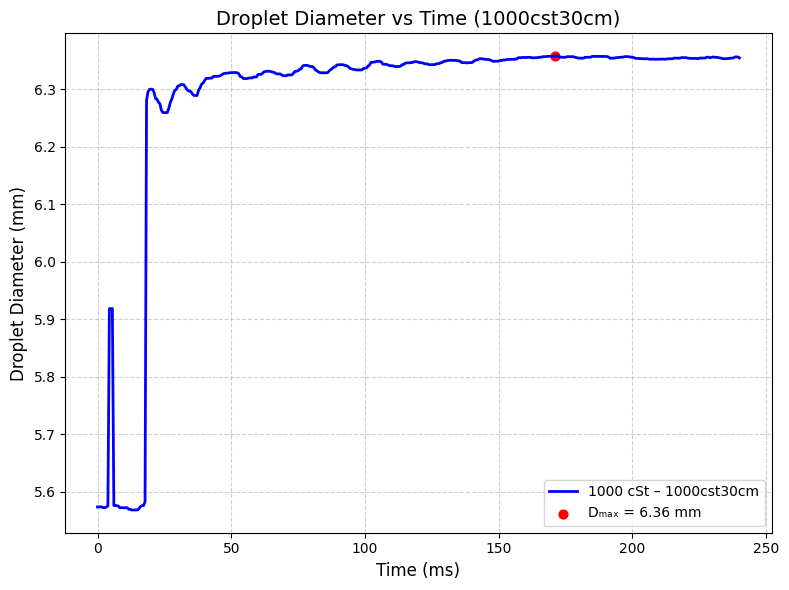

In [ ]:
# ==============================================================
# 🧩 STEP 1: Install & Import Libraries
# ==============================================================
!pip install opencv-python-headless scikit-image tqdm matplotlib --quiet

import os, zipfile, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io
from scipy.signal import medfilt
from scipy.interpolate import interp1d
import pandas as pd

# ==============================================================
# 🗂 STEP 2: Upload Dataset
# ==============================================================
from google.colab import files
print("⬆ Upload your 1000cst zip file (e.g., 1000cst5cm.zip, 1000cst10cm.zip, etc.)")
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

# ==============================================================
# ⚙ Constants
# ==============================================================
FPS = 1800                     # frame rate (Hz)
time_per_frame = 1 / FPS       # seconds per frame
pixels_per_mm = 36.14          # calibration (from ImageJ)
mm_per_pixel = 1 / pixels_per_mm

# ==============================================================
# ⚙ STEP 3: Droplet Processing Function
# ==============================================================
def ensure_gray(img):
    """Convert to grayscale if needed"""
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def process_zip(zip_path):
    """Extracts frames, detects droplet, computes diameter (mm) vs time"""
    extract_folder = zip_path.replace('.zip','')
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_folder)

    frames = sorted([f for f in os.listdir(extract_folder) if f.lower().endswith('.tif')])
    if not frames:
        raise RuntimeError(f"No .tif files found in {zip_path}")

    diam_mm, times = [], []

    for i, fname in enumerate(tqdm(frames, desc=f"Processing {zip_path}")):
        img = io.imread(os.path.join(extract_folder, fname))
        gray = ensure_gray(img)

        # --- Optional crop (focus region, adjust as needed) ---
        roi = gray[500:800, :]

        # --- Thresholding ---
        blur = cv2.GaussianBlur(roi, (5,5), 0)
        _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if np.mean(roi[th==255]) > np.mean(roi[th==0]):
            th = cv2.bitwise_not(th)

        # --- Morphological cleaning ---
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
        th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)

        # --- Find droplet contour ---
        cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            diam_mm.append(np.nan)
            times.append(i * time_per_frame)
            continue

        c = max(cnts, key=cv2.contourArea)
        area_px = cv2.contourArea(c)
        eq_d_px = 2 * np.sqrt(area_px / np.pi)
        eq_d_mm = eq_d_px * mm_per_pixel

        diam_mm.append(eq_d_mm)
        times.append(i * time_per_frame)

    # --- Handle missing data and smooth curve ---
    diam = np.array(diam_mm, float)
    idx = np.arange(len(diam))
    if np.any(np.isnan(diam)):
        f = interp1d(idx[~np.isnan(diam)], diam[~np.isnan(diam)], fill_value="extrapolate")
        diam = f(idx)
    diam = medfilt(diam, 5)

    # --- Compute Metrics ---
    t_ms = np.array(times) * 1000
    D0 = np.median(diam[:5])
    Dmax = np.nanmax(diam)
    Tmax = t_ms[np.argmax(diam)]
    Beta = Dmax / D0

    # --- Save results ---
    csv_name = f"results_{zip_path.replace('.zip', '.csv')}"
    pd.DataFrame({"Time_ms": t_ms, "Diameter_mm": diam}).to_csv(csv_name, index=False)
    print(f"\n✅ Saved results to {csv_name}")
    print(f"Initial Diameter D₀ = {D0:.2f} mm")
    print(f"Maximum Diameter Dₘₐₓ = {Dmax:.2f} mm")
    print(f"Spreading Factor β = {Beta:.3f}")

    return t_ms, diam, Dmax, Tmax, D0, Beta

# ==============================================================
# 📊 STEP 4: Run for 1000 cSt
# ==============================================================
t_ms, diam_mm, Dmax, Tmax, D0, Beta = process_zip(zip_name)

plt.figure(figsize=(8,6))
plt.plot(t_ms, diam_mm, 'b-', linewidth=2, label=f"1000 cSt – {zip_name.replace('.zip','')}")
plt.scatter(Tmax, Dmax, color='r', s=40, label=f"Dₘₐₓ = {Dmax:.2f} mm")
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Droplet Diameter (mm)", fontsize=12)
plt.title(f"Droplet Diameter vs Time ({zip_name.replace('.zip','')})", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
